# Analyse de la base Sirene via SQLite 

Voici la correction de l'analyse de la base sirène. 
Nous allons réaliser l'analyse en utilisant SQLite et Pandas simultanément. 
Ce n'est pas obligatoire pour cette taille de fichier mais ça permet d'illustrer la mise en étoile 
d'un schéma. 

## Sources
Ce notebook suppose que le fichier a été télécharger [ici](https://links-biblio.lille.inria.fr/paperman/datas/base-sirene.csv.gz) et décompresser. Attention, ce fichier pèse 500mo décompressé. 

In [1]:
import pandas
import sqlite3
import csv
import matplotlib.pyplot as plot

###  Exploration du fichier. 

Il est possible de réaliser la phase d'exploration du fichier, en chargeant qu'une petite partie du fichier en mémoire. Le fichier en question se nomme `base-siren.csv`. On execute simplement la commande `head` en ligne de commande pour tronquer le fichier (ici à la ligne 100). 

In [2]:
!head -n100 base-sirene.csv > short.csv 

In [3]:
df = pandas.read_csv("short.csv", delimiter=";")
df

SIREN  NIC           siret Statut de diffusion de l'établissement  \
0   956506828  303  95650682800303                                      O   
1   956508469  387  95650846900387                                      O   
2   956510663  241  95651066300241                                      O   
3   500672357   26  50067235700026                                      O   
4   500672381   26  50067238100026                                      O   
..        ...  ...             ...                                    ...   
94  500952056   17  50095205600017                                      O   
95  500952254   34  50095225400034                                      O   
96  500954409   16  50095440900016                                      O   
97  500955794   28  50095579400028                                      O   
98  500971890   16  50097189000016                                      O   

   Date de création de l'établissement  \
0                           1990-06-01   
1                           2006-03-01   
2                           1998-01-01   
3                           2012-10-11   
4                           2012-06-29   
..                                 ...   
94                          2007-10-15   
95                          2011-07-01   
96                          2007-05-14   
97                          2016-05-03   
98                          2007-10-25   

   Tranche de l'effectif de l'établissement  \
0                            6 à 9 salariés   
1                            6 à 9 salariés   
2               Etablissement non employeur   
3                                       NaN   
4                                       NaN   
..                                      ...   
94                                      NaN   
95              Etablissement non employeur   
96                                      NaN   
97                                      NaN   
98                                      NaN   

    Année de la tranche d'effectif de l'établissement  \
0                                              2017.0   
1                                              2017.0   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
94                                                NaN   
95                                                NaN   
96                                                NaN   
97                                                NaN   
98                                                NaN   

   Activité principale de l'établissement  \
0                                  46.69B   
1                                  52.29B   
2                                   31.1C   
3                                  64.30Z   
4                                  41.10D   
..                                    ...   
94                                 70.22Z   
95                                 47.71Z   
96                                 93.12Z   
97                                 47.99A   
98                                 46.19B   

   Date de la dernière mise à jour de l'établissement Etablissement siège  \
0                           2019-06-24T16:13:08+02:00                 non   
1                           2019-06-24T16:13:08+02:00                 non   
2                           2007-05-22T04:47:38+02:00                 non   
3                           2012-11-08T10:24:28+01:00                 oui   
4                           2019-02-20T12:42:47+01:00                 oui   
..                                                ...                 ...   
94                          2009-02-17T05:11:58+01:00                 oui   
95                          2019-02-20T12:42:47+01:00                 non   
96                          2016-07-29T15:03:27+02:00                 non   
97               

## SQLite et Python

On peut communiquer avec une base de donnée SQLite en Python directement. Il faut faire attention à ne jamais tout charger en mémoire afin de ne pas la saturer.

In [4]:
!rm siren.db
db = sqlite3.connect("siren.db") # création de la base de donnée 

L'intérêt d'utiliser Python et de pouvoir se limiter à seulement les éléments qui vont nous intéresser et de ne pas importer les colonnes inutiles. 
Nous allons garder uniquement les colonnes suivantes, que l'on stock dans le dictionnaire `important_keys`. 
Dans ce dictionnaire, on associe des labels plus agréable à manipuler aux vrais labels utiliser dans le fichier.

In [5]:
important_keys = {
"siren"             : "SIREN",
"effectif"          : "Tranche de l'effectif de l'établissement",
"code_postal"       : "Code postal de l'établissement",
"commune"           : "Commune de l'établissement",
"état_administratif": "Etat administratif de l'établissement",
"dénomination"      : "Dénomination usuelle de l'établissement",
"section"           : "Section de l'établissement",
"sous_section"      : "Sous-section de l'établissement",
"division"          : "Division de l'établissement",
"groupe"            : "Groupe de l'établissement",
"classe"            : "Classe de l'établissement",
"addresse"          : "Adresse de l'établissement",
"date_fermeture"    : "Date de fermeture de l'établissement",
"date_creation"     : "Date de création de l'établissement",
"position"          : "Géolocalisation de l'établissement"
}

Nous aurons également besoin de l'index où apparait chacune de ses colonnes dans le fichier. 
On le construit à partir de l'entête calculer par pandas.

In [6]:
keys = list(df.keys())
important_keys_index = {k:keys.index(v) for k,v in important_keys.items()}
print(important_keys_index)

{'siren': 0, 'effectif': 5, 'code_postal': 16, 'commune': 17, 'état_administratif': 40, 'dénomination': 44, 'section': 58, 'sous_section': 59, 'division': 60, 'groupe': 61, 'classe': 62, 'addresse': 63, 'date_fermeture': 64, 'date_creation': 4, 'position': 107}


### Approche naïve

Nous allons maintenant créer un table SQLite qui contient les données qui nous intéresse.
Nous pouvons générer la requête en Python pour ne pas la taper à la main. 
L'objectif est de stocker dans une seule table SQLite la table des faits et d'executer des requêtes SQL pour générer les tableaux croiser que l'on transmet à Pandas.

In [7]:
query = "CREATE TABLE table_des_faits ({})".format(",\n\t".join(important_keys.keys()))
print("Query que nous allons executer:\n", query)
c = db.execute(query, important_keys)

Query que nous allons executer:
 CREATE TABLE table_des_faits (siren,
	effectif,
	code_postal,
	commune,
	état_administratif,
	dénomination,
	section,
	sous_section,
	division,
	groupe,
	classe,
	addresse,
	date_fermeture,
	date_creation,
	position)


Nous devons maintenant faire ingérer à SQLite les données du fichier CSV.
Nous devons lire le fichier (en Python) et filtrer les données inutiles. 


In [8]:
indices = set(important_keys_index.values())
print(indices)

{0, 64, 4, 5, 40, 107, 44, 16, 17, 58, 59, 60, 61, 62, 63}


Nous aurons également besoin de la liste des colonnes de la table trié par leur index. On stock ça une fois pour toute dans une variable. 

In [9]:
important_keys_trie = sorted(important_keys, key=lambda e:important_keys_index[e])
print(important_keys_trie)

['siren', 'date_creation', 'effectif', 'code_postal', 'commune', 'état_administratif', 'dénomination', 'section', 'sous_section', 'division', 'groupe', 'classe', 'addresse', 'date_fermeture', 'position']


On peut maintenant préparer la requête d'insertion. On utilise des *placeholder* afin d'appeler la fonction executemany et d'accélerer sensiblement l'ingestion. Pour plus de détails, vous pouvez lire la documentation du module [sqlite3](https://docs.python.org/3/library/sqlite3.html)

In [10]:
query = "INSERT INTO table_des_faits ({}) VALUES ({})".format(
    ",".join(important_keys_trie), 
    ",".join(["?" for _ in range(len(important_keys))]))
print(query) #Le nombre de ? est égale au nombre de colonne. 

INSERT INTO table_des_faits (siren,date_creation,effectif,code_postal,commune,état_administratif,dénomination,section,sous_section,division,groupe,classe,addresse,date_fermeture,position) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)


On peut maintenant parcourir le fichier et transmettre chaque ligne à la base de donnée via 
la commande `executemany`. On doit faire attention à ne pas stocker en mémoire toute les lignes. 
Le plus simple pour ça consiste à simplement utiliser des opérations fonctionnelles. 
Nous allons simplifier la lecture du fichier CSV à l'aide module `csv` dont l'utilisation est aisée.

In [11]:
def filtre_ligne(e):
    """
    Fonction qui prend une ligne de text
    et qui retourne un tuple contenant uniquement les colonnes
    importantes
    """
    return tuple(map(lambda e:e[1], filter(lambda e:e[0] in indices, enumerate(e))))

with open("base-sirene.csv") as fichier_raw:
    fichier_parse = csv.reader(fichier_raw, delimiter=';')
    next(fichier_parse) # on dépile la première ligne
    lignes = map(filtre_ligne, fichier_parse) # l'execution ne se lance pas ici
    db.executemany(query, lignes) # déplie l'itérateur et insère les lignes 
    db.commit()

On peut vérifier que le nombre de lignes inséré est le bon. 

In [12]:
list(db.execute("SELECT COUNT(*) FROM table_des_faits"))[0][0]

468466

In [13]:
!wc -l base-sirene.csv

468467 base-sirene.csv


### Quelques tableaux croisés simple

On peut immédiatement utiliser pandas via SQL pour produire des tableaux croisés. 

In [14]:
communes_etats = pandas.read_sql("SELECT commune, état_administratif, COUNT(*) as Count FROM table_des_faits GROUP BY commune, état_administratif", db)
communes_etats.pivot_table("Count", index="commune", columns="état_administratif")

état_administratif    Actif   Fermé
commune                            
ALLENNES LES MARAIS   303.0   407.0
ALLENNES-LES-MARAIS    10.0     4.0
ANNOEULLIN            979.0  1560.0
ANSTAING              162.0   194.0
ARMENTIERES          2807.0  5045.0
...                     ...     ...
WAVRIN                878.0  1236.0
WERVICQ SUD           574.0   694.0
WERVICQ-SUD            16.0    11.0
WICRES                 57.0    58.0
WILLEMS               379.0   508.0

[121 rows x 2 columns]

On voit des soucis de formattage au niveau des communes, ça peut aisément se régler via une simple requête SQL. 

In [15]:
db.execute("UPDATE table_des_faits SET commune = REPLACE(commune, '-',' ')")
db.commit()

In [16]:
communes_etats = pandas.read_sql("SELECT commune, état_administratif, COUNT(*) as Count FROM table_des_faits GROUP BY commune, état_administratif", db)
communes_etats.pivot_table("Count", index="commune", columns="état_administratif")

état_administratif    Actif   Fermé
commune                            
ALLENNES LES MARAIS   313.0   411.0
ANNOEULLIN            979.0  1560.0
ANSTAING              162.0   194.0
ARMENTIERES          2807.0  5045.0
AUBERS                271.0   249.0
...                     ...     ...
WATTRELOS            2926.0  5709.0
WAVRIN                878.0  1236.0
WERVICQ SUD           590.0   705.0
WICRES                 57.0    58.0
WILLEMS               379.0   508.0

[96 rows x 2 columns]

In [17]:
%%time
communes_etats = pandas.read_sql("SELECT commune, effectif, COUNT(*) as Count FROM table_des_faits GROUP BY commune, effectif", db)

CPU times: user 383 ms, sys: 52.4 ms, total: 435 ms
Wall time: 434 ms


In [18]:
pivot = communes_etats.pivot_table("Count", index="commune", columns="effectif", aggfunc=sum).fillna(0)
pivot

effectif                     0 salarié  1 ou 2 salariés  10 à 19 salariés  \
commune                                                                     
ALLENNES LES MARAIS   390.0       10.0             23.0               3.0   
ANNOEULLIN           1313.0       35.0             95.0              18.0   
ANSTAING              214.0        3.0             19.0               1.0   
ARMENTIERES          3681.0      114.0            262.0              60.0   
AUBERS                267.0        7.0             25.0               2.0   
...                     ...        ...              ...               ...   
WATTRELOS            4388.0      118.0            248.0              56.0   
WAVRIN               1091.0       25.0             68.0              16.0   
WERVICQ SUD           724.0       17.0             46.0               6.0   
WICRES                 68.0        3.0              7.0               0.0   
WILLEMS               480.0       20.0             35.0               5.0   

effectif             100 à 199 salariés  1000 à 1999 salariés  \
commune                                                         
ALLENNES LES MARAIS                 0.0                   0.0   
ANNOEULLIN                          0.0                   0.0   
ANSTAING                            0.0                   0.0   
ARMENTIERES                        11.0                   2.0   
AUBERS                              0.0                   0.0   
...                                 ...                   ...   
WATTRELOS                           7.0                   1.0   
WAVRIN                              0.0                   0.0   
WERVICQ SUD                         0.0                   0.0   
WICRES                              0.0                   0.0   
WILLEMS                             0.0                   0.0   

effectif             20 à 49 salariés  200 à 249 salariés  \
commune                                                     
ALLENNES LES MARAIS               2.0                 0.0   
ANNOEULLIN                       15.0                 0.0   
ANSTAING                          0.0                 0.0   
ARMENTIERES                      41.0                 3.0   
AUBERS                            1.0                 0.0   
...                               ...                 ...   
WATTRELOS                        37.0                 1.0   
WAVRIN                            9.0                 0.0   
WERVICQ SUD                       8.0                 0.0   
WICRES                            0.0                 0.0   
WILLEMS                           5.0                 0.0   

effectif             2000 à 4999 salariés  250 à 499 salariés  3 à 5 salariés  \
commune                                                                         
ALLENNES LES MARAIS                   0.0                 0.0             7.0   
ANNOEULLIN                            0.0                 1.0            38.0   
ANSTAING                              0.0                 0.0             4.0   
ARMENTIERES                           0.0                 1.0           126.0   
AUBERS                                0.0                 0.0             7.0   
...                                   ...                 ...             ...   
WATTRELOS                             0.0                 2.0           120.0   
WAVRIN                                0.0                 0.0            35.0   
WERVICQ SUD                           0.0                 0.0            13.0   
WICRES                                0.0                 0.0             3.0   
WILLEMS                               0.0                 1.0            13.0   

effectif             50 à 99 salariés  500 à 999 salariés  \
commune                                                     
ALLENNES LES MARAIS               1.0                 0.0   
ANNOEULLIN                        4.0                 0.0   
ANSTAING                          0.0                 0.0   

On voit que le temps de calcul est raisonnable mais le dataset est plutôt petit. On peut quand même accélérer les requêtes en ajoutant des indexes.

In [19]:
db.execute("CREATE INDEX commune_effectifs ON table_des_faits (commune, effectif)")

In [20]:
%%time
communes_etats = pandas.read_sql("SELECT commune, effectif, COUNT(*) as Count FROM table_des_faits GROUP BY commune, effectif", db)

CPU times: user 45.9 ms, sys: 115 µs, total: 46.1 ms
Wall time: 45.6 ms


On gagne un facteur 10 immédiatement. 

On peut regarder aisément le rapport entre la taille et le nombre de fermeture addministrative. 

In [21]:
effectif_etats = pandas.read_sql("SELECT effectif, état_administratif, COUNT(*) as Count FROM table_des_faits GROUP BY effectif, état_administratif", db)
pivot = effectif_etats.pivot_table("Count", index="effectif", columns="état_administratif", aggfunc=sum).fillna(0)

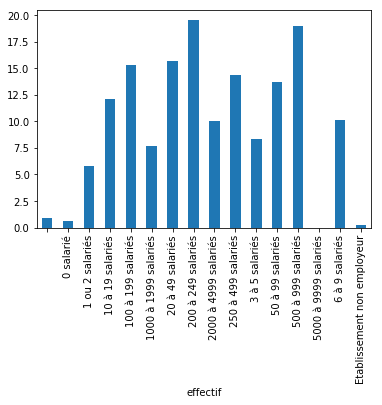

In [22]:
(pivot["Actif"]/pivot["Fermé"]).plot(kind="bar")

La visualisation à trié par ordre alphabétique et non pas par nombre de salarié, ce qui la rend inutilisable. On peut arranger ça aisément. 

In [23]:
list(pivot.index)

['',
 '0 salarié',
 '1 ou 2 salariés',
 '10 à 19 salariés',
 '100 à 199 salariés',
 '1000 à 1999 salariés',
 '20 à 49 salariés',
 '200 à 249 salariés',
 '2000 à 4999 salariés',
 '250 à 499 salariés',
 '3 à 5 salariés',
 '50 à 99 salariés',
 '500 à 999 salariés',
 '5000 à 9999 salariés',
 '6 à 9 salariés',
 'Etablissement non employeur']

In [24]:
reindex = sorted(list(pivot.index)[:-1], key=lambda e:int(e.split(" ")[0]) if e else -1)
reindex.insert(1, 'Etablissement non employeur')

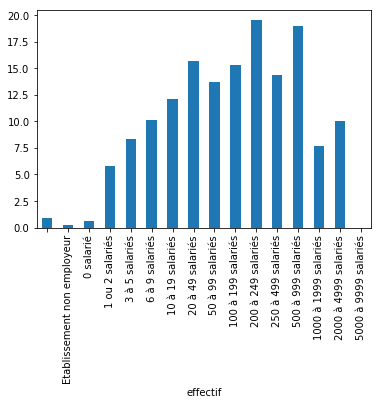

In [25]:
pivot = pivot.reindex(reindex)
(pivot["Actif"]/pivot["Fermé"]).plot(kind="bar")

## Modélisation en cube et schéma en étoile

La modélisation précédante est relativement limité. Il est compliqué de faire des analyses par granularité 
et les performances peuvent être mauvaises quand les données sont très grosses. 
Pour éviter ça, on peut introduire un schéma en étoile qui va pré-agrégé les données en fonction de leur granularité. 

Il faut dans un premier temps identifié les dimensions d'intérêts. On les modélise en associant à chaque dimension une liste de colonne ordonnée par granularité.

In [26]:
important_keys

{'siren': 'SIREN',
 'effectif': "Tranche de l'effectif de l'établissement",
 'code_postal': "Code postal de l'établissement",
 'commune': "Commune de l'établissement",
 'état_administratif': "Etat administratif de l'établissement",
 'dénomination': "Dénomination usuelle de l'établissement",
 'section': "Section de l'établissement",
 'sous_section': "Sous-section de l'établissement",
 'division': "Division de l'établissement",
 'groupe': "Groupe de l'établissement",
 'classe': "Classe de l'établissement",
 'addresse': "Adresse de l'établissement",
 'date_fermeture': "Date de fermeture de l'établissement",
 'date_creation': "Date de création de l'établissement",
 'position': "Géolocalisation de l'établissement"}

In [27]:
dimensions = {
    'effectif':['effectif'], 
    'localisation':['commune', 'code_postal', 'addresse', 'position'],
    'creation': ['date_creation'],
    'fermeture': ['date_fermeture'],
    'etat':["état_administratif"],
    'description':['section', 'sous_section', 'division', 'groupe', 'classe', 'dénomination'] # ordonné par nombre de valeur !=
}

Nous allons traiter les dates différemment puisque nous voulons agréger par année, par mois et pas seulement par date précise. Nous allons construire directement depuis la table des faits les tables de dimensions qui nous intéresse. 

In [28]:
%%time 
for dimension, colonnes in dimensions.items():
    colonnes =  colonnes
    colonnes = ", ".join(colonnes)
    query = "CREATE TABLE {} (id INTEGER PRIMARY KEY, {})".format(dimension, colonnes)
    print(query) # Affiche la requête executée
    db.execute(query)
    query = "INSERT INTO {} ({colonnes}) SELECT DISTINCT {colonnes} FROM table_des_faits"
    query = query.format(dimension, colonnes=colonnes)
    print(query) # Affiche l'insertion dans la table
    db.execute(query)
    query = "CREATE INDEX {dimension}_dim ON {dimension}({})".format(colonnes, dimension=dimension)
    query = query.format(dimension, colonnes=colonnes)
    db.execute(query)
db.commit()

CREATE TABLE effectif (id INTEGER PRIMARY KEY, effectif)
INSERT INTO effectif (effectif) SELECT DISTINCT effectif FROM table_des_faits
CREATE TABLE localisation (id INTEGER PRIMARY KEY, commune, code_postal, addresse, position)
INSERT INTO localisation (commune, code_postal, addresse, position) SELECT DISTINCT commune, code_postal, addresse, position FROM table_des_faits
CREATE TABLE creation (id INTEGER PRIMARY KEY, date_creation)
INSERT INTO creation (date_creation) SELECT DISTINCT date_creation FROM table_des_faits
CREATE TABLE fermeture (id INTEGER PRIMARY KEY, date_fermeture)
INSERT INTO fermeture (date_fermeture) SELECT DISTINCT date_fermeture FROM table_des_faits
CREATE TABLE etat (id INTEGER PRIMARY KEY, état_administratif)
INSERT INTO etat (état_administratif) SELECT DISTINCT état_administratif FROM table_des_faits
CREATE TABLE description (id INTEGER PRIMARY KEY, section, sous_section, division, groupe, classe, dénomination)
INSERT INTO description (section, sous_section, div

Pour créer le Cube, il faut maintenant transformer chaque ligne de la table des faits en une ligne utilisant 
les id de dimensions avec les bonnes valeurs. On peut aisément créer la table en utilisant `SIREN` comme identifiant de ligne. On pourrait ajouter des clefs étrangère pour garantir la cohérence de la base, mais ce n'est pas non plus indispensable. 

In [29]:
query = "CREATE TABLE cube (siren, {})".format(", ".join(dimensions))
print(query)
db.execute(query)

CREATE TABLE cube (siren, effectif, localisation, creation, fermeture, etat, description)


La requête suivante est compliqué à écrire, on le fait à la main pour ne pas se tromper. 

In [30]:
query = """
INSERT INTO cube(siren, effectif, localisation, creation, fermeture, etat, description)
SELECT t.siren, e.id, l.id, c.id, f.id, etat.id, d.id 
FROM table_des_faits t, effectif e, localisation l, creation c, fermeture f, etat, description d 
WHERE 
    t.effectif = e.effectif AND
    t.commune = l.commune AND 
    t.code_postal= l.code_postal AND
    t.addresse = l.addresse AND 
    t.position = l.position AND
    t.date_creation = c.date_creation AND 
    t.date_fermeture = f.date_fermeture AND 
    t.section = d.section AND
    t.sous_section = d.sous_section AND
    t.état_administratif = etat.état_administratif AND
    t.division = d.division AND
    t.groupe = d.groupe AND
    t.classe = d.classe AND 
    t.dénomination = d.dénomination    
"""
# Ouf. 

In [31]:
%%time 
db.execute(query) # La requête serait excessivement longue sans les index.
db.commit()

CPU times: user 2.23 s, sys: 1.21 s, total: 3.44 s
Wall time: 3.85 s


In [32]:
db.commit()

## Gestion des tables temporelles

Les deux tables temporelles contiennent des données désagrégé. Il peut être pertinent de les traité pour permettre d'avoir une vue par année et par mois. 


In [33]:
db.execute("ALTER TABLE creation ADD COLUMN année")
db.execute("ALTER TABLE creation ADD COLUMN mois")
db.execute("ALTER TABLE fermeture ADD COLUMN année")
db.execute("ALTER TABLE fermeture ADD COLUMN mois")


In [34]:
db.execute("UPDATE creation SET année=SUBSTR(date_creation, 0, 5),mois=SUBSTR(date_creation, 0, 8)")
db.execute("UPDATE fermeture SET année=SUBSTR(date_fermeture, 0, 5),mois=SUBSTR(date_fermeture, 0, 8)")
db.commit()

Ajouter des index permet de retrouver rapidement les colonnes dont on a besoin en cas de changement de granularité. 

In [35]:
db.execute("CREATE INDEX _create ON creation (année, mois, date_creation)")
db.execute("CREATE INDEX _fermeture ON fermeture (année, mois, date_fermeture)")
db.commit()

## Quelques tableaux croisés
On peut reprendre les tableaux croisés de la version naïve. 

In [36]:
query =""" 
SELECT e.effectif, e2.état_administratif, COUNT(*) as Count 
FROM cube, etat e2, effectif e 
WHERE 
    cube.etat=e2.id AND
    cube.effectif=e.id 
GROUP BY cube.etat, cube.effectif
"""
effectif_etats = pandas.read_sql(query, db)
pivot = effectif_etats.pivot_table("Count", index="effectif", columns="état_administratif").fillna(0)

In [37]:
pivot

état_administratif              Actif     Fermé
effectif                                       
                             113994.0  130498.0
0 salarié                      2851.0    4462.0
1 ou 2 salariés               11752.0    2015.0
10 à 19 salariés               3234.0     267.0
100 à 199 salariés              429.0      28.0
1000 à 1999 salariés             23.0       3.0
20 à 49 salariés               2212.0     141.0
200 à 249 salariés               78.0       4.0
2000 à 4999 salariés             10.0       1.0
250 à 499 salariés              158.0      11.0
3 à 5 salariés                 6278.0     754.0
50 à 99 salariés                880.0      64.0
500 à 999 salariés               57.0       3.0
5000 à 9999 salariés              2.0       0.0
6 à 9 salariés                 3637.0     358.0
Etablissement non employeur   34410.0  149852.0

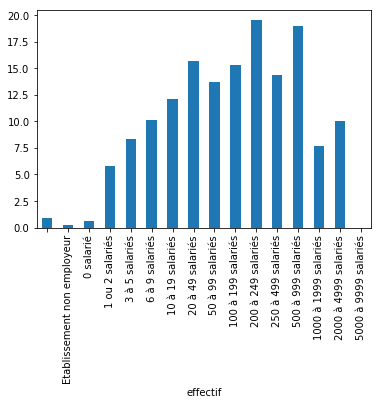

In [38]:
pivot = pivot.reindex(reindex)
(pivot["Actif"]/pivot["Fermé"]).plot(kind="bar")

On retrouve bien la même chose ! Faisons varier l'année de création maintenant ! 
On récupère la liste des années:

In [148]:
%%time 
query =""" 
SELECT e.effectif, c.année, COUNT(*) as Count 
FROM cube, etat e2, effectif e, creation c
WHERE 
    cube.etat=e2.id AND
    cube.effectif=e.id AND
    e.effectif != "" AND
    cube.creation =c.id AND 
    cast(c.année as number) > 1960 AND 
    cast(c.année as number) < 2018 AND
    e2.état_administratif = "Actif"
GROUP BY cube.etat, cube.effectif, cube.creation
"""
df = pandas.read_sql(query, db)
df

CPU times: user 243 ms, sys: 8.35 ms, total: 251 ms
Wall time: 251 ms


In [149]:
df

effectif année  Count
0                 0 salarié  2006      2
1                 0 salarié  1998      5
2                 0 salarié  2012      1
3                 0 salarié  2007      3
4                 0 salarié  2015      3
...                     ...   ...    ...
22693  2000 à 4999 salariés  1983      2
22694  2000 à 4999 salariés  1984      1
22695  2000 à 4999 salariés  1984      1
22696  5000 à 9999 salariés  2016      1
22697  5000 à 9999 salariés  1983      1

[22698 rows x 3 columns]

In [150]:
pivot = df.pivot_table("Count", index='année', columns="effectif", aggfunc="sum").fillna(0)
pivot = pivot[reindex[1:]]

In [151]:
pivot.style.background_gradient(cmap='Blues')

## Création d'entreprise par ville (importantes)

In [174]:
%%time 
query =""" 
SELECT c2.commune, c.année, COUNT(*) as Count 
FROM cube, localisation c2, creation c
WHERE
    cube.localisation = c2.id AND
    cube.creation =c.id AND 
    cast(c.année as number) > 1950 AND
    cast(c.année as number) < 2018 
GROUP BY cube.localisation, cube.creation
"""
df = pandas.read_sql(query, db)
df

CPU times: user 922 ms, sys: 188 ms, total: 1.11 s
Wall time: 1.11 s


In [175]:
pivot = df.pivot_table("Count", index="année", columns="commune", aggfunc=sum).fillna(0)

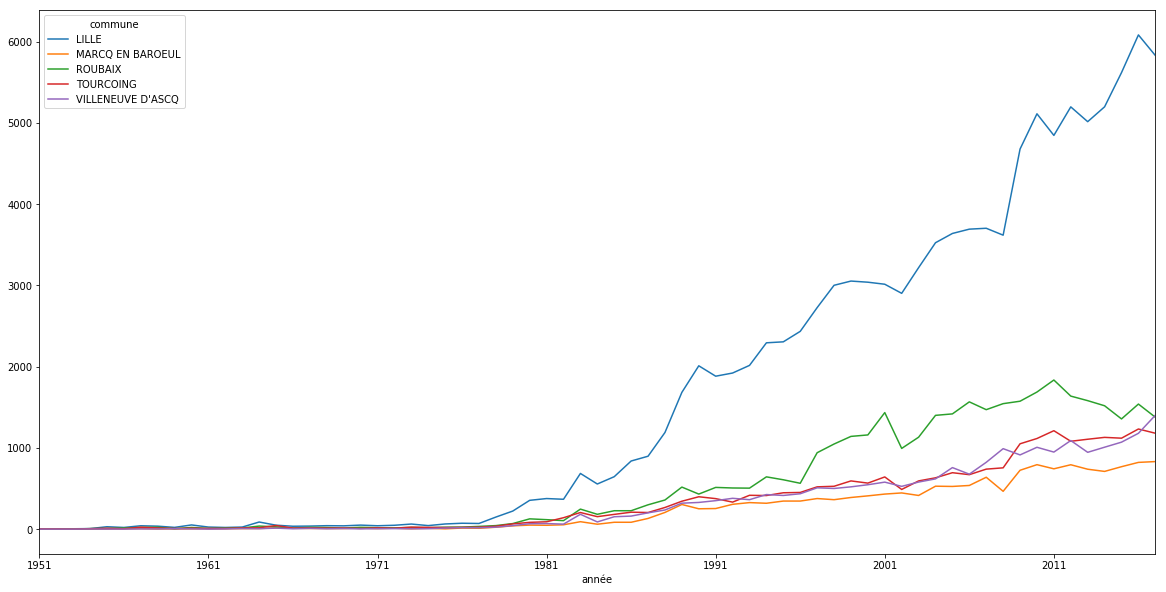

In [176]:
sommes = pivot.apply(sum)
total = sum(sommes)
pivot[sommes[sommes > total/30].keys()].plot(figsize=(20,10))

## Affinée sur Lille

CPU times: user 957 ms, sys: 208 ms, total: 1.17 s
Wall time: 1.16 s


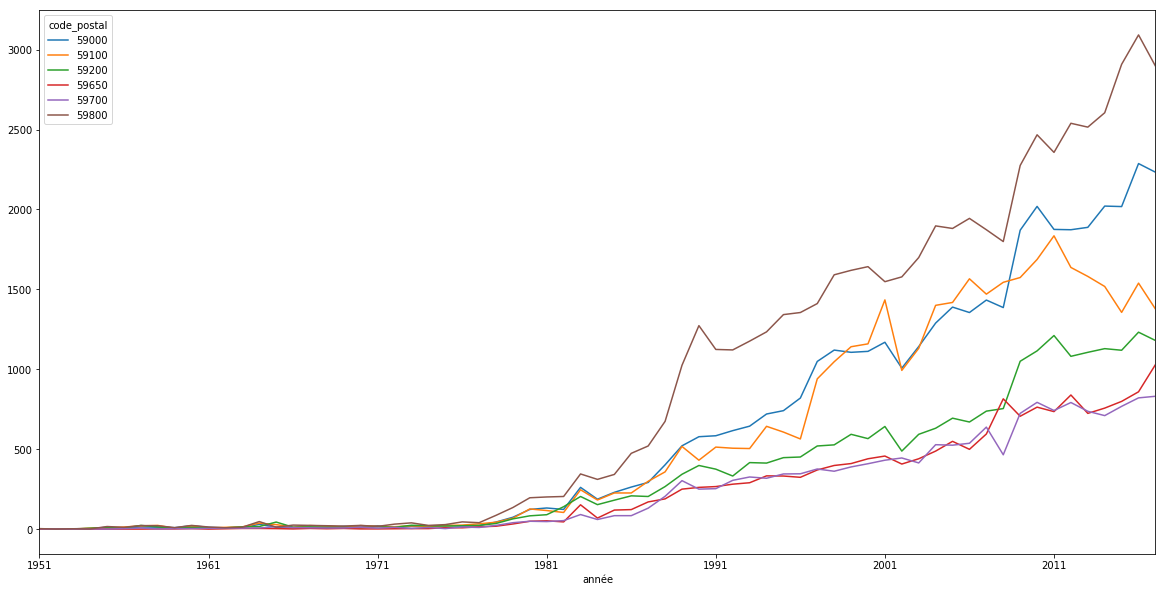

In [177]:
%%time 
query =""" 
SELECT c2.code_postal, c.année, COUNT(*) as Count 
FROM cube, localisation c2, creation c
WHERE
    cube.localisation = c2.id AND
    cube.creation =c.id AND 
    cast(c.année as number) > 1950 AND
    cast(c.année as number) < 2018 
GROUP BY cube.localisation, cube.creation
"""
df = pandas.read_sql(query, db)
pivot = df.pivot_table("Count", index="année", columns="code_postal", aggfunc=sum).fillna(0)
sommes = pivot.apply(sum)
total = sum(sommes)
pivot[sommes[sommes > total/30].keys()].plot(figsize=(20,10))